In [1]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.0 MB/s 


In [2]:
!pip install fastdist

In [3]:
import numpy as np
import pandas as pd
import re
import gensim
import glob
import os
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from datetime import datetime
import codecs
import unidecode
from itertools import product
from math import log
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
import gc
from fastdist import fastdist

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def divide(data, labels):
    clusters = set(labels)
    clusters_data = []
    for cluster in clusters:
        clusters_data.append(data[labels == cluster, :])
    return clusters_data

def get_centroids(clusters):
    centroids = []
    for cluster_data in clusters:
        centroids.append(cluster_data.mean(axis=0))
    return centroids

In [7]:
def cohesion(data, labels):
    clusters = sorted(set(labels))
    sse = 0
    for cluster in clusters:
        cluster_data = data[labels == cluster, :]
        centroid = cluster_data.mean(axis = 0)
        sse += ((cluster_data - centroid)**2).sum()
    return sse

def separation(data, labels, cohesion_score):
    # calculate separation as SST - SSE
    return cohesion(data, np.zeros(data.shape[0])) - cohesion_score

def SST(data):
    c = get_centroids([data])
    return ((data - c) ** 2).sum()

def SSE(clusters, centroids):
    result = 0
    for cluster, centroid in zip(clusters, centroids):
        result += ((cluster - centroid) ** 2).sum()
    return result

# Clear the store before running each time
within_cluster_dist_sum_store = {}
def within_cluster_dist_sum(cluster, centroid, cluster_id):
    if cluster_id in within_cluster_dist_sum_store:
        return within_cluster_dist_sum_store[cluster_id]
    else:
        result = (((cluster - centroid) ** 2).sum(axis=1)**.5).sum()
        within_cluster_dist_sum_store[cluster_id] = result
    return result

def RMSSTD(data, clusters, centroids):
    df = data.shape[0] - len(clusters)
    attribute_num = data.shape[1]
    return (SSE(clusters, centroids) / (attribute_num * df)) ** .5

# equal to separation / (cohesion + separation)
def RS(data, clusters, centroids):
    sst = SST(data)
    sse = SSE(clusters, centroids)
    return (sst - sse) / sst

def DB_find_max_j(clusters, centroids, i):
    max_val = 0
    max_j = 0
    for j in range(len(clusters)):
        if j == i:
            continue
        cluster_i_stat = within_cluster_dist_sum(clusters[i], centroids[i], i) / clusters[i].shape[0]
        cluster_j_stat = within_cluster_dist_sum(clusters[j], centroids[j], j) / clusters[j].shape[0]
        val = (cluster_i_stat + cluster_j_stat) / (((centroids[i] - centroids[j]) ** 2).sum() ** .5)
        if val > max_val:
            max_val = val
            max_j = j
    return max_val

def DB(data, clusters, centroids):
    result = 0
    for i in range(len(clusters)):
        result += DB_find_max_j(clusters, centroids, i)
    return result / len(clusters)

def XB(data, clusters, centroids):
    sse = SSE(clusters, centroids)
    min_dist = ((centroids[0] - centroids[1]) ** 2).sum()
    for centroid_i, centroid_j in list(product(centroids, centroids)):
        if (centroid_i - centroid_j).sum() == 0:
            continue
        dist = ((centroid_i - centroid_j) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
    return sse / (data.shape[0] * min_dist)

In [8]:
def stat_clust(data, labels, verbose = 200, dist = True):
  clusters = sorted(set(labels))
  i = 0
  n_c = len(clusters)
  k = n_c // verbose

  cluster_stat = []
  print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3], '|', 'Count clusters: ', n_c)
  for cluster in clusters:
    if verbose and (i % k == 0):
      print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3], '|', i,  'progress: ', round(i/ n_c, 3)*100, '%')
    dict_c = dict()
    cluster_data = data[labels == cluster, :]
    centroid = cluster_data.mean(axis = 0)
    clust_uniq = np.unique(cluster_data, axis=0)
    count_uni = clust_uniq.shape[0]
    dict_c['cluster'] = cluster
    dict_c['centr_dist'] = ((cluster_data - centroid)**2).sum()
    dict_c['count_all'] = cluster_data.shape[0]
    dict_c['count_uniq'] = count_uni
    #dist_nod_e = []
    if dist:
      min_e = 10000000
      max_e = -1

      for i in range(count_uni):
        for j in range(i+1, count_uni):
          dist_nod = fastdist.euclidean(clust_uniq[i], clust_uniq[j])
          min_e = min(min_e, dist_nod)
          max_e = max(max_e, dist_nod)

      dict_c['min_euclidean'] = min_e
      dict_c['max_euclidean'] = max_e

    i += 1
    gc.collect()

    cluster_stat.append(dict_c)
  return pd.DataFrame(cluster_stat)

In [9]:
# GridSearch results for English human texts
list_grid_human = []
list_grid_human.append({'cohesion': 8571.319560256108, 'separation': 12140.398810480781, 'calinski_harabaz_score': 195.9886519420432, 'RMSSTD': 0.028304474174194103, 'RS': 0.5861608676387597, 'silhouette': -0.1965591040947928, 'significance': 1000, 'neighbors': 50, 'cluster_num': 3867})
list_grid_human.append({'cohesion': 8146.544521532364, 'separation': 12565.173849204526, 'calinski_harabaz_score': 685.8482355045229, 'RMSSTD': 0.027525935621499728, 'RS': 0.6066697907092811, 'silhouette': -0.137816160048998, 'significance': 1000, 'neighbors': 100, 'cluster_num': 1210})
list_grid_human.append({'cohesion': 8571.319560256108, 'separation': 12140.398810480781, 'calinski_harabaz_score': 195.9886519420432, 'RMSSTD': 0.028304474174194103, 'RS': 0.5861608676387597, 'silhouette': -0.1965591040947928, 'significance': 100000, 'neighbors': 50, 'cluster_num': 3867})
list_grid_human.append({'cohesion': 8146.544521532364, 'separation': 12565.173849204526, 'calinski_harabaz_score': 685.8482355045229, 'RMSSTD': 0.027525935621499728, 'RS': 0.6066697907092811, 'silhouette': -0.137816160048998, 'significance': 100000, 'neighbors': 100, 'cluster_num': 1210})

In [10]:
# GridSearch results for English bot texts
list_grid_bot = []
list_grid_bot.append({'cohesion': 2749.449792574569, 'separation': 5000.656659175672, 'calinski_harabaz_score': 777.6272060819349, 'RMSSTD': 0.027281668292086288, 'RS': 0.6452371577485043, 'silhouette': -0.07547212191489622, 'significance': 1000, 'neighbors': 50, 'cluster_num': 433})
list_grid_bot.append({'cohesion': 2780.602040187679, 'separation': 4969.504411562562, 'calinski_harabaz_score': 1167.3792288173, 'RMSSTD': 0.027424728941625044, 'RS': 0.6412175681071163, 'silhouette': -0.060082838204908326, 'significance': 1000, 'neighbors': 100, 'cluster_num': 284})
list_grid_bot.append({'cohesion': 2749.449792574569, 'separation': 5000.656659175672, 'calinski_harabaz_score': 777.6272060819349, 'RMSSTD': 0.027281668292086288, 'RS': 0.6452371577485043, 'silhouette': -0.07547212191489622, 'significance': 100000, 'neighbors': 50, 'cluster_num': 433})
list_grid_bot.append({'cohesion': 2780.602040187679, 'separation': 4969.504411562562, 'calinski_harabaz_score': 1167.3792288173, 'RMSSTD': 0.027424728941625044, 'RS': 0.6412175681071163, 'silhouette': -0.060082838204908326, 'significance': 100000, 'neighbors': 100, 'cluster_num': 284})


In [11]:
list_grid_human = pd.DataFrame(list_grid_human)
list_grid_bot = pd.DataFrame(list_grid_bot)


In [12]:
list_grid_human.sort_values('calinski_harabaz_score', ascending=False)

,cohesion,separation,calinski_harabaz_score,RMSSTD,RS,silhouette,significance,neighbors,cluster_num
1,8146.544522,12565.173849,685.848236,0.027526,0.606670,-0.137816,1000,100,1210
3,8146.544522,12565.173849,685.848236,0.027526,0.606670,-0.137816,100000,100,1210
0,8571.319560,12140.398810,195.988652,0.028304,0.586161,-0.196559,1000,50,3867
2,8571.319560,12140.398810,195.988652,0.028304,0.586161,-0.196559,100000,50,3867


In [13]:
list_grid_bot.sort_values('calinski_harabaz_score', ascending=False)

,cohesion,separation,calinski_harabaz_score,RMSSTD,RS,silhouette,significance,neighbors,cluster_num
1,2780.602040,4969.504412,1167.379229,0.027425,0.641218,-0.060083,1000,100,284
3,2780.602040,4969.504412,1167.379229,0.027425,0.641218,-0.060083,100000,100,284
0,2749.449793,5000.656659,777.627206,0.027282,0.645237,-0.075472,1000,50,433
2,2749.449793,5000.656659,777.627206,0.027282,0.645237,-0.075472,100000,50,433


**The Root-mean-square standard deviation (𝑅𝑀𝑆𝑆𝑇𝐷)**
is the square root of the pooled sample variance of all the
attributes. It measures the homogeneity of the formed
clusters. 

**R-squared (𝑅𝑆) ** is the ratio of sum of squares
between clusters to the total sum of squares of the whole data
set. It measures the degree of difference between clusters.


𝑅𝑀𝑆𝑆𝑇𝐷 decreases as 𝑁𝐶 increases.
𝑅𝑆 = (𝑇𝑆𝑆 −𝑆𝑆𝐸)/𝑇 𝑆𝑆 (𝑇𝑆𝑆 - Total Sum of Squares), and 𝑇𝑆𝑆 = 𝑆𝑆𝐸 +𝑆𝑆𝐵 (𝑆𝑆𝐵 - Between group Sum of Squares) which is a constant number for a certain data set. Thus, 𝑅𝑆 increases as 𝑁𝐶 increases.
Looking further into these two indices, we can find out that they only take either separation or compactness into account. (𝑅𝑆 only consider separation, and 𝑅𝑀𝑆𝑆𝑇𝐷 only considers compactness). As the property
of monotonicity, the curves of 𝑅𝑀𝑆𝑆𝑇𝐷 and 𝑅𝑆 will be either upward or downward. It is claimed that the optimal cluster number is reached at the shift point of the curves.



**The Calinski-Harabasz index (𝐶𝐻)** evaluates the cluster validity based on the average between- and withincluster sum of squares. The optimal cluster number is determined by maximizing the value of these indices. take a form of
$𝐼𝑛𝑑𝑒𝑥 = (𝑎⋅ 𝑆𝑒𝑝𝑎𝑟𝑎𝑡𝑖𝑜𝑛)/(𝑏⋅ 𝐶𝑜𝑚𝑝𝑎𝑐𝑡𝑛𝑒𝑠𝑠)$, where 𝑎 and 𝑏 are weights.

**The Silhouette index (𝑆)** validates the clustering performance based on the pairwise difference of betweenand within-cluster distances. In addition, the optimal cluster number is determined by maximizing the value of this index.



### Permutation test
$H_0\colon$ median metrics are the same for human and bot.

$H_1\colon$ median metrics are not the same for human and bot.

In [14]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

In [15]:
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [16]:
# permutation functions for median

def permutation_t_stat_2s(sample1, sample2):
    return np.median(sample1) - np.median(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [17]:
# permutation functions for mean

def permutation_t_stat_2s_mean(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def permutation_null_dist_2s_mean(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s_mean(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s_mean(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s_mean(sample1, sample2)
    
    null_distr = permutation_null_dist_2s_mean(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

## English - check result

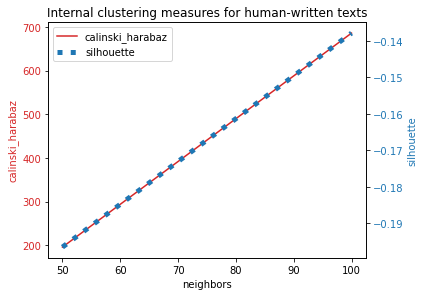

In [18]:
# Figure for human texts

fig, ax1 = plt.subplots()

k = list_grid_human.sort_values('neighbors')
color = 'tab:red'
ax1.set_xlabel('neighbors')
ax1.set_ylabel('calinski_harabaz', color=color)
lns1 = ax1.plot(k['neighbors'], k['calinski_harabaz_score'], color=color, label = "calinski_harabaz")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
lns2 = ax2.plot(k['neighbors'], k['silhouette'], color=color, label = "silhouette", linestyle = ':', linewidth = 5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(title = "Metrics")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)
plt.title("Internal clustering measures for human-written texts")
plt.show()

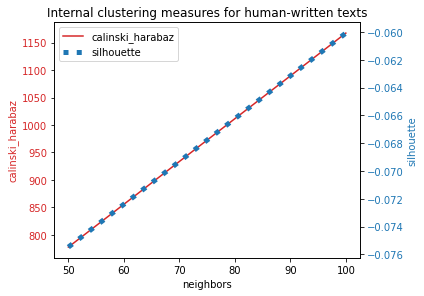

In [19]:
# Figure for bot texts

fig, ax1 = plt.subplots()

k = list_grid_bot.sort_values('neighbors')
color = 'tab:red'
ax1.set_xlabel('neighbors')
ax1.set_ylabel('calinski_harabaz', color=color)
lns1 = ax1.plot(k['neighbors'], k['calinski_harabaz_score'], color=color, label = "calinski_harabaz")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
lns2 = ax2.plot(k['neighbors'], k['silhouette'], color=color, label = "silhouette", linestyle = ':', linewidth = 5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(title = "Metrics")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)
plt.title("Internal clustering measures for human-written texts")
plt.show()

In [21]:
X_human = pd.read_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_en/10000_n_2gramm_human_en.csv')
X_bot = pd.read_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_bot_en/10000_n_2gramm_bot_en.csv')

In [22]:
X_human.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'ind', 'name',
       'cluster_100050', 'cluster_1000100', 'cluster_10000050',
       'cluster_100000100'],
      dtype='object')

In [23]:
X_bot.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'ind', 'name',
       'cluster_100050', 'cluster_1000100', 'cluster_10000050',
       'cluster_100000100'],
      dtype='object')

In [24]:
list_col = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

In [25]:
# for human texts
en_human = stat_clust(np.array(X_human[list_col]), X_human['cluster_100000100'],  verbose = 10, dist = False )

2022-01-26 00:05:57.474 | Count clusters:  1210
2022-01-26 00:05:57.474 | 0 progress:  0.0 %
2022-01-26 00:06:11.540 | 121 progress:  10.0 %
2022-01-26 00:06:23.783 | 242 progress:  20.0 %
2022-01-26 00:06:36.061 | 363 progress:  30.0 %
2022-01-26 00:06:48.849 | 484 progress:  40.0 %
2022-01-26 00:07:00.936 | 605 progress:  50.0 %
2022-01-26 00:07:13.107 | 726 progress:  60.0 %
2022-01-26 00:07:25.220 | 847 progress:  70.0 %
2022-01-26 00:07:37.399 | 968 progress:  80.0 %
2022-01-26 00:07:49.557 | 1089 progress:  90.0 %


In [26]:
# for bot texts
en_bot = stat_clust(np.array(X_bot[list_col]), X_bot['cluster_100000100'],  verbose = 10, dist = False )

2022-01-26 00:08:01.643 | Count clusters:  284
2022-01-26 00:08:01.644 | 0 progress:  0.0 %
2022-01-26 00:08:04.816 | 28 progress:  9.9 %
2022-01-26 00:08:07.615 | 56 progress:  19.7 %
2022-01-26 00:08:10.396 | 84 progress:  29.599999999999998 %
2022-01-26 00:08:13.186 | 112 progress:  39.4 %
2022-01-26 00:08:15.928 | 140 progress:  49.3 %
2022-01-26 00:08:18.670 | 168 progress:  59.199999999999996 %
2022-01-26 00:08:21.411 | 196 progress:  69.0 %
2022-01-26 00:08:24.117 | 224 progress:  78.9 %
2022-01-26 00:08:26.828 | 252 progress:  88.7 %
2022-01-26 00:08:29.573 | 280 progress:  98.6 %


In [27]:
en_human.to_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_en/10000_statistics_human_en.csv')
en_bot.to_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_bot_en/10000_statistics_bot_en.csv')

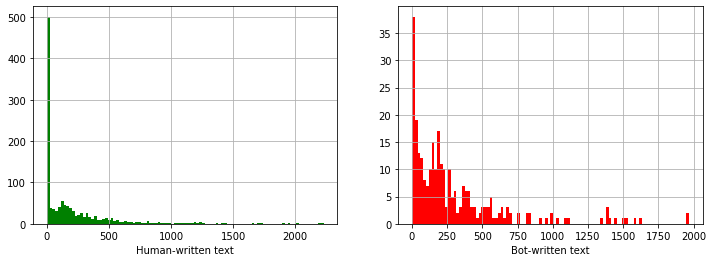

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(en_human['count_all'].sort_values(ascending = False)[10 :], bins = 100, color = 'g')
plt.xlabel('Human-written text')

plt.subplot(1,2,2)
plt.grid()
plt.hist( en_bot['count_all'].sort_values(ascending = False)[5 :], bins = 100, color = 'r')
plt.xlabel('Bot-written text');

In [29]:
en_human['norm_clusters'] = en_human['count_all'] / sum(en_human['count_all'])

In [30]:
sum(en_human['norm_clusters'])

1.0000000000000104

In [31]:
en_bot['norm_clusters'] = en_bot['count_all'] / sum(en_bot['count_all'])

In [32]:
sum(en_bot['norm_clusters'])

1.0

In [33]:
#median number of vectors in a cluster

np.random.seed(0)

human_median_scores = list(map(np.median, get_bootstrap_samples(np.array(en_human['norm_clusters']), 5000)))
bot_median_scores = list(map(np.median, get_bootstrap_samples(np.array(en_bot['norm_clusters']), 5000)))

print("95% confidence interval for average number of vectors in a cluster (Human-written):",  percentile_interval(human_median_scores, 0.05))
print("95% confidence interval for average number of vectors in a cluster (Bot-written):",  percentile_interval(bot_median_scores, 0.05))
print("Estimated difference avg number of vectors in a cluster:", np.median(en_human['norm_clusters']) - np.median(en_bot['norm_clusters']))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(human_median_scores, bot_median_scores)))
print("95% confidence interval for the difference between median number of vectors in a cluster:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for average number of vectors in a cluster (Human-written): [0.00012064 0.00020137]
95% confidence interval for average number of vectors in a cluster (Bot-written): [0.00089664 0.00115591]
Estimated difference avg number of vectors in a cluster: -0.0008475069760659423
95% confidence interval for the difference between median number of vectors in a cluster: [-0.00099444 -0.00072041]


In [34]:
np.random.seed(0)
res = permutation_test_2s(en_human['norm_clusters'], en_bot['norm_clusters'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))
print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')


Permutation test: t = -0.000848, p = 0.000200
---------------------------------------------------------------
H0 is rejected:
Median metrics are not the same for Human and Bot texts.
---------------------------------------------------------------


In [35]:
# median distance to centroid

np.random.seed(0)

human_median_scores = list(map(np.median, get_bootstrap_samples(np.array(en_human['centr_dist']), 5000)))
bot_median_scores = list(map(np.median, get_bootstrap_samples(np.array(en_bot['centr_dist']), 5000)))

print("95% confidence interval for average distance to centroid in a cluster (Human-written):",  percentile_interval(human_median_scores, 0.05))
print("95% confidence interval for average distance to centroid in a cluster (Bot-written):",  percentile_interval(bot_median_scores, 0.05))
print("Estimated difference average distance to centroid in a cluster:", np.median(en_human['centr_dist']) - np.median(en_bot['centr_dist']))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(human_median_scores, bot_median_scores)))
print("95% confidence interval for the difference between median distance to centroid in a cluster:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for average distance to centroid in a cluster (Human-written): [0.0188026  0.04995215]
95% confidence interval for average distance to centroid in a cluster (Bot-written): [0.48792405 1.169965  ]
Estimated difference average distance to centroid in a cluster: -0.8880997337071175
95% confidence interval for the difference between median distance to centroid in a cluster: [-1.13993149 -0.45365966]


In [36]:
# permutation for median distance to centroid

np.random.seed(0)
res = permutation_test_2s(en_human['centr_dist'], en_bot['centr_dist'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')

Permutation test: t = -0.888100, p = 0.000200
---------------------------------------------------------------
H0 is rejected:
Median metrics are not the same for Human and Bot texts.
---------------------------------------------------------------


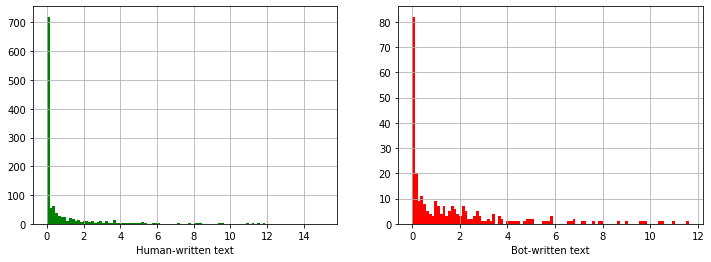

In [37]:
# distribution distance to centroid

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(en_human['centr_dist'].sort_values(ascending = False)[10 :], bins = 100, color = 'g')
plt.xlabel('Human-written text')

plt.subplot(1,2,2)
plt.grid()
plt.hist(en_bot['centr_dist'].sort_values(ascending = False)[10 :], bins = 100, color = 'r')
plt.xlabel('Bot-written text');

In [38]:
# mean distance to centroid
np.random.seed(0)

human_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(en_human['centr_dist']), 5000)))
bot_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(en_bot['centr_dist']), 5000)))

print("95% confidence interval for mean distance to centroid in a cluster (Human-written):",  percentile_interval(human_mean_scores, 0.05))
print("95% confidence interval for mean distance to centroid in a cluster (Bot-written):",  percentile_interval(bot_mean_scores, 0.05))
print("Estimated difference mean distance to centroid in a cluster:", np.mean(en_human['centr_dist']) - np.mean(en_bot['centr_dist']))

delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(human_mean_scores, bot_mean_scores)))
print("95% confidence interval for the difference between mean distance to centroid in a cluster:",  
      percentile_interval(delta_mean_scores, 0.05))

95% confidence interval for mean distance to centroid in a cluster (Human-written): [ 0.99166893 18.08243426]
95% confidence interval for mean distance to centroid in a cluster (Bot-written): [ 1.92570377 25.10648377]
Estimated difference mean distance to centroid in a cluster: -3.058170831427949
95% confidence interval for the difference between mean distance to centroid in a cluster: [-23.76091866  15.47716567]


In [39]:
# permutation for mean distance to centroid

np.random.seed(0)
res = permutation_test_2s_mean(en_human['centr_dist'], en_bot['centr_dist'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')

Permutation test: t = -3.058171, p = 0.845800
---------------------------------------------------------------
H0 is not rejected:
Median metrics are the same for Human and Bot texts.
---------------------------------------------------------------
